<a href="https://colab.research.google.com/github/nsubbaian/FrequentistML/blob/master/Project5/FML_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forests

Select a dataset and perform a classification or regression on the dataset using the random forest algorithm in sci-kit learn. Plot the feature importance.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV

SEED = 42

# Selected Dataset: http://archive.ics.uci.edu/ml/datasets/Forest+Fires
# Dataset Description: https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.names
# Chosen so it's good for regression (with numerical, not categorical features, and the target is a continuous number)

dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

# removed categorical feautures
dataset = dataset.drop(columns = {'month', 'day'})

# Shuffle and then split training data into 80% train, 10% validation and 10% test
training, test = np.split(dataset.sample(frac=1), [int(.9*len(dataset))])
print("Length of dataset:", len(dataset))
print( "Length of training:", len(training))
print("Length of test:", len(test))

training.head()

Length of dataset: 517
Length of training: 465
Length of test: 52


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
259,7,4,91.8,170.9,692.3,13.7,23.7,40,1.8,0.0,1.38
369,4,5,91.0,276.3,825.1,7.1,13.8,77,7.6,0.0,0.00
15,6,5,93.3,141.2,713.9,13.9,22.9,44,5.4,0.0,0.00
485,2,4,95.0,135.5,596.3,21.3,30.6,28,3.6,0.0,2.07
506,1,2,91.0,166.9,752.6,7.1,18.5,73,8.5,0.0,0.00


In [52]:
RFtrain_X, RFtrain_Y = training.iloc[:, :10], np.log(training.iloc[:, 10]+ 1)
RFtest_X, RFtest_Y = test.iloc[:, :10], np.log(test.iloc[:, 10]+1)


# Random Grid: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 150, num = 30)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 50, num = 25)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf':  [1, 2, 4],
               'bootstrap': bootstrap}
print(random_grid)

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 9, verbose=3, random_state=42, n_jobs = -1)
rf_random.fit(RFtrain_X, RFtrain_Y)

{'n_estimators': [0, 5, 10, 15, 20, 25, 31, 36, 41, 46, 51, 56, 62, 67, 72, 77, 82, 87, 93, 98, 103, 108, 113, 118, 124, 129, 134, 139, 144, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 9 folds for each of 50 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 447 out of 450 | elapsed:   51.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   51.7s finished


RandomizedSearchCV(cv=9, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [53]:
print("Best Parameters: ", rf_random.best_params_)

ypred = rf_random.best_estimator_.predict(RFtest_X)
RFMSE_test = np.square(np.subtract(RFtest_Y, ypred)).mean()
print("Best Parameters MSE", RFMSE_test)


regr_base = RandomForestRegressor(n_estimators = 10, random_state = 42)
regr_base.fit(RFtrain_X, RFtrain_Y)
ypred = regr_base.predict(RFtest_X)
RFMSE_test = np.square(np.subtract(RFtest_Y, ypred)).mean()
print("Baseline MSE", RFMSE_test)

Best Parameters:  {'n_estimators': 103, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': True}
Best Parameters MSE 1.4499736936662755
Baseline MSE 1.644105060237626


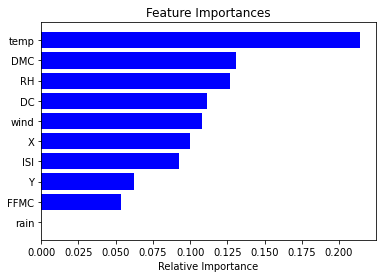

In [54]:
features = RFtrain_X.columns.values
importances = regr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()